In [20]:
import sys
import torch
sys.path.append("../")
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import ot
import time
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
from tqdm import tqdm
import cv2
from lib.linear_gromov import LGW_dist,LPGW_embedding,LPGW_dist,LGW_dist
from lib.opt import opt_lp,emd_lp
from lib.gromov import gromov_wasserstein, cost_matrix_d, tensor_dot_param, tensor_dot_func, gwgrad_partial1, partial_gromov_wasserstein, partial_gromov_ver1
from lib.gromov import GW_dist,MPGW_dist, PGW_dist_with_penalty
from utils import *
#from lib.lgw.utils import *

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#from ot.gromov._utils import init_matrix
#from ot.gromov import cg,gwggrad,gwloss,init_matrix

In [2]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current working directory:", current_directory)

def normalize(X):
    M=cost_matrix_d(X,X)
    return X/np.sqrt(M.max())

Current working directory: /home/baly/projects/Linearized_Partial_Gromov_Wasserstein/ellipses


In [3]:
# Define parameters
Nx = 10
Ny = 10
N = Nx * Ny
x_len = 50
y_len = 50

In [4]:
# Load ellipses
ells = np.loadtxt("./ellipses_data.txt").reshape((Nx,Ny,x_len,y_len))
ells.shape

(10, 10, 50, 50)

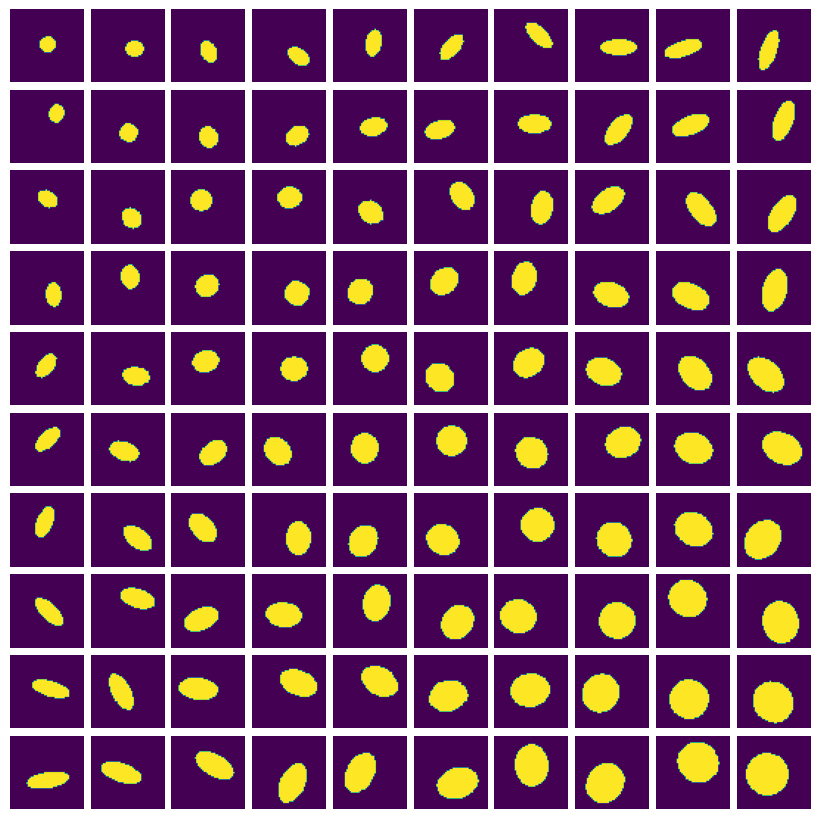

In [5]:
# Plot ellipses
fig, ax = plt.subplots(Nx, Ny, figsize=(8,8))
for i in range(Nx):
    for j in range(Ny):
        ax[i, j].imshow(ells[i, j])
        ax[i, j].set_axis_off()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.savefig("results/ellipse_data.png",dpi=200)

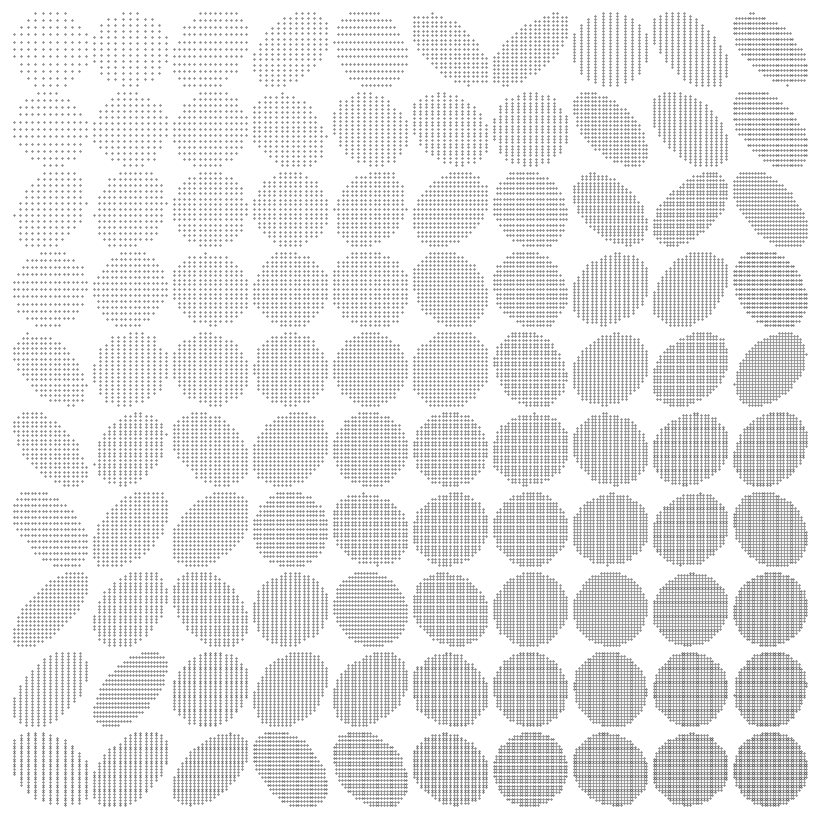

In [6]:
# Create mm-spaces from imgs (we will normalize the distance)
ells_flat = ells.reshape(N,x_len,y_len)

posns = []
heights = []
Ms = []
LAMBDA_MAX = 0

for i in range(N):
    img = ells_flat[i]
    supp = np.dstack(np.where(img > 0))[0]
    
    height = img[supp[:,0],supp[:,1]]
    M = cost_matrix_d(supp, supp)
    supp=normalize(supp)
    M=M/M.max()
    posns.append(supp)
    heights.append(height)
    Ms.append(M)
    LAMBDA_MAX = 1.0 #max(LAMBDA_MAX, Ms[i].max() ** 2)

# Plot ellipses
fig, ax = plt.subplots(Nx, Ny, figsize=(8,8))
for i in range(Nx):
    for j in range(Ny):
        data=posns[i*10+j]
        ax[i, j].scatter(data[:,0],data[:,1],s=0.1,color='black')
        ax[i,j].axis('off') 
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
    
        
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

In [8]:
# compute  GW distance
st = time.time()        
dist = np.zeros((N,N))

for i in range(N):
    M1 = Ms[i]
    height1 = heights[i] / np.sum(heights[i])
    n=height1.shape[0]
    for j in range(i+1, N):
        M2 = Ms[j]
        height2 = heights[j] / np.sum(heights[j])
        gamma = gromov_wasserstein(M1, M2, height1, height2, G0=None,thres=1,numItermax=500*n,numItermax_gw=1000, tol=1e-5,log=False, verbose=False,line_search=False)
        dist[i, j] = np.sqrt(GW_dist(M1, M2, gamma))
            
dist += dist.T
et = time.time()
wall_time = np.round(et-st,2)

result={}
result['dist'], result['wall_time'] = dist, wall_time
torch.save(result, 'results/gw.pt')

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


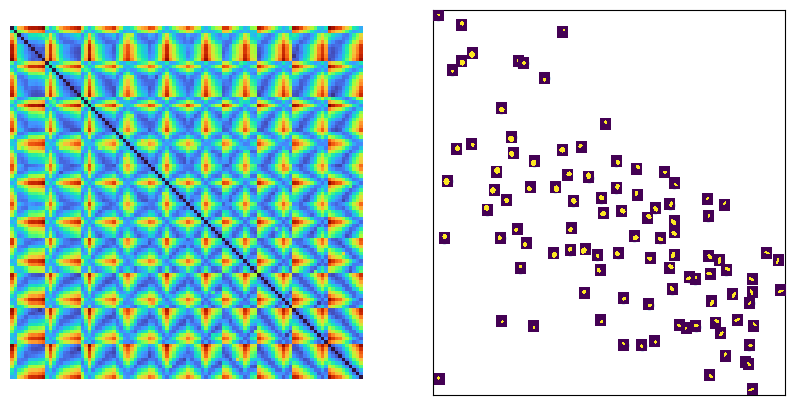

In [9]:
# Plot
result = torch.load('results/gw.pt')
gw,gw_time = result['dist'],result['wall_time']
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(gw,cmap = "turbo")
ax[0].axis("off")


mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding = mds.fit_transform(gw)
plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1])

ax[1].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.show()

In [7]:
#Compute LPGW distances for all reference measures
def LPGW_dist(embedding1, embedding2, Lambda):
    (K1_tilde,p1_tilde,mass_p1c), (K2_tilde,p2_tilde,mass_p2c) = embedding1, embedding2
    p12 = np.minimum(p1_tilde, p2_tilde)
    M = (K1_tilde-K2_tilde)**2 
    dist = p12.dot(M).dot(p12.reshape(-1,1))[0]
    penalty_1 = Lambda*(p1_tilde.sum()**2+p2_tilde.sum()**2-2*p12.sum()**2)
    penalty_2 = Lambda*(mass_p1c+mass_p2c)
    return dist, penalty_1+penalty_2

st = time.time()        
refs=torch.load('results/refs.pt')
WEIGHT=300.0
N=100
for Lambda in [0.1, 0.3, 0.5]:
    dist = np.zeros((N,N))
    for i in range(N):
        M1 = Ms[i]
        height1 = heights[i] / WEIGHT

        n = height1.shape[0]
        for j in range(i + 1, N):
            M2 = Ms[j]
            height2 = heights[j] / WEIGHT
            gamma = partial_gromov_ver1(M1, M2, height1, height2, G0=None, Lambda=Lambda, thres=1, numItermax=500 * n,numItermax_gw=1000, tol=1e-10, log=False, verbose=False, line_search=True)
            pgw_trans, pgw_penalty = PGW_dist_with_penalty(M1, M2, gamma, height1, height2, Lambda)
            dist[i, j] = np.sqrt(pgw_trans + pgw_penalty)

    dist[dist < 0] = 0
    dist += dist.T
    et = time.time()
    wall_time = et - st
    print(f"PGW computation for Lambda {Lambda}: {np.round(wall_time, 2)}s")
    result={}
    result['dist'],result['wall_time']=dist,wall_time
    torch.save(result,f'results/pgw_%0.3f.pt'%Lambda)


    # compute the LPGW 
    dist_per_ref = []
    times_per_ref = []
    # compute the embeddings
    for k in range(len(refs)):
        embeddings = []
        supp, M, height = refs[k]
        st = time.time()
        height1 = height/WEIGHT
        n = height1.shape[0]
        for i in range(N):
            #compute the embedding
            height2 = heights[i]/WEIGHT
            supp2 = posns[i]
            #Compute Wasserstein coupling
            M_ot = ot.dist(supp,posns[i])
            G0, _ = opt_lp(height1,height2,M_ot,Lambda)
        
            #Compute GW coupling with initial coupling set to Wasserstein coupling G0
            #constC, hC1, hC2 = init_matrix(M, Ms[i], height, heights[i], "square_loss")

            G = partial_gromov_ver1(M, Ms[i], height1, height2, G0=G0,Lambda=Lambda,thres=1,numItermax=500*n,numItermax_gw=1000, tol=1e-5,log=False, verbose=False,line_search=True) 
            
            embedding, _ = LPGW_embedding(M,supp2,height1,height2,Lambda,gamma=G,loss='square')
            embeddings.append(embedding)

            
        dist2 = np.zeros((N,N))
        for i in range(N):
            embedding1 = embeddings[i]
            for j in range(i + 1, N):
                embedding2 = embeddings[j]
                trans,penalty = LPGW_dist(embedding1,embedding2,Lambda)
                dist2[i, j] = np.sqrt(trans+penalty)

        dist2 += dist2.T
        et = time.time()
        print("Time for LPGW with ref space "+ str(k) + ": " + str(np.round((et-st)/60,2)) + " min")

        times_per_ref.append(et-st)
        dist_per_ref.append(dist2)

    result={}
    result['dist_per_ref'],result['times_per_ref']=dist_per_ref,times_per_ref
    torch.save(result,'results/lpgw_%0.3f.pt'%Lambda)


PGW computation for Lambda 0.1: 1557.68s
Time for LPGW with ref space 0: 0.12 min
Time for LPGW with ref space 1: 0.07 min
Time for LPGW with ref space 2: 0.06 min
Time for LPGW with ref space 3: 0.01 min
Time for LPGW with ref space 4: 0.02 min
Time for LPGW with ref space 5: 0.05 min
Time for LPGW with ref space 6: 0.1 min
Time for LPGW with ref space 7: 0.1 min
Time for LPGW with ref space 8: 0.03 min
PGW computation for Lambda 0.3: 1067.71s
Time for LPGW with ref space 0: 0.04 min
Time for LPGW with ref space 1: 0.07 min
Time for LPGW with ref space 2: 0.06 min
Time for LPGW with ref space 3: 0.01 min
Time for LPGW with ref space 4: 0.02 min
Time for LPGW with ref space 5: 0.05 min
Time for LPGW with ref space 6: 0.1 min
Time for LPGW with ref space 7: 0.1 min
Time for LPGW with ref space 8: 0.03 min
PGW computation for Lambda 0.5: 1076.71s
Time for LPGW with ref space 0: 0.04 min
Time for LPGW with ref space 1: 0.07 min
Time for LPGW with ref space 2: 0.06 min
Time for LPGW with r

In [18]:
refs=torch.load('results/refs.pt')

for Lambda in [0.007,0.1,1.0]:
    result=torch.load('results_save/pgw_%0.3f.pt'%Lambda)
    pgw=result['dist']
    time_pgw=result['wall_time']
    result=torch.load('results_save/lpgw_%0.3f.pt'%Lambda)
    lpgw_per_ref=result['dist_per_ref']
    times_per_ref=result['times_per_ref']
    print('wall_clock time in min for PGW is', time_pgw/60)
    print("        MRE       PCC      time in mins     no. of points")
    for i in range(9):
        m_pgw = np.ma.masked_equal(pgw, 0.0, copy=False)
        m_lpgw = np.ma.masked_equal(lpgw_per_ref[i], 0.0, copy=False)
        print("Ref " + str(i+1) + ":  " 
              + str(np.round(np.mean(np.abs(m_pgw - m_lpgw)/m_pgw),4)) 
              + "    " 
              + str(np.round(np.corrcoef(m_pgw.flatten(),m_lpgw.flatten())[1,0],4))
              + "    "
              + str(np.round((times_per_ref[i])/60,2))
              + "             "
              + str(np.sum(refs[i][2] != 0)))

wall_clock time in min for PGW is 15.823047006130219
        MRE       PCC      time in mins     no. of points
Ref 1:  0.5817    0.7515    0.63             441
Ref 2:  0.4245    0.8646    1.19             676
Ref 3:  0.4251    0.8574    1.14             625
Ref 4:  0.6362    0.7308    0.09             52
Ref 5:  0.4631    0.8103    0.68             289
Ref 6:  0.4569    0.8541    0.9             545
Ref 7:  0.501    0.8469    1.93             882
Ref 8:  0.501    0.8469    1.92             882
Ref 9:  0.5205    0.7807    0.57             317
wall_clock time in min for PGW is 16.36214553117752
        MRE       PCC      time in mins     no. of points
Ref 1:  0.3449    0.9212    0.29             441
Ref 2:  0.4214    0.9309    0.7             676
Ref 3:  0.3817    0.9456    0.64             625
Ref 4:  0.9207    0.6801    0.06             52
Ref 5:  0.3299    0.8308    0.32             289
Ref 6:  0.4604    0.9148    0.91             545
Ref 7:  0.5309    0.885    1.29             882
Re

In [9]:
#Compute LGW distances for all reference measures
refs=torch.load('results/refs.pt')
Gs_per_ref = []
dist_per_ref = []
times_per_ref = []
idx = 0
for k in range(len(refs)):
    supp,M,height = refs[k]
    Gs = []
    BPs = []
    st = time.time()
    height1=height/height.sum()
    n=height1.shape[0]
    for i in range(N):
        height2=heights[i]/heights[i].sum()
        #Compute Wasserstein coupling
        M_ot = ot.dist(supp,posns[i])
        G0 = ot.emd(height1,height2,M_ot)
        
        #Compute GW coupling with initial coupling set to Wasserstein coupling G0
        #constC, hC1, hC2 = init_matrix(M, Ms[i], height, heights[i], "square_loss")
        
        G =gromov_wasserstein(M, Ms[i], height1, height2, G0=G0,thres=1,numItermax=500*n,numItermax_gw=1000, tol=1e-5,log=False, verbose=False,line_search=True) 
        #cg(height, heights[i], 0, 1, f, df, G0, armijo=False, C1=M, C2=Ms[i], constC=constC)
        Gs.append(G)
        
        #barycentric projection of GW coupling P
        BP = (np.divide(G.T,height1).T).dot(posns[i])
        BPs.append(BP)
    dist = np.zeros((N,N))
    for i in range(N):
        for j in range(i + 1, N):
            C1_tilde=cost_matrix_d(BPs[i],BPs[i])
            C2_tilde=cost_matrix_d(BPs[j],BPs[j])
            dist[i, j] = np.sqrt(LGW_dist(C1_tilde,C2_tilde,height1))

    dist += dist.T
    et = time.time()
    print("Time for LGW with ref space "+ str(k) + ": " + str(np.round((et-st)/60,2)) + " min")
    
    times_per_ref.append(et-st)
    Gs_per_ref.append(Gs)
    dist_per_ref.append(dist)

result={}
result['dist_per_ref'],result['times_per_ref']=dist_per_ref,times_per_ref
torch.save(result,'results/lgw.pt')

Time for LGW with ref space 0: 1.32 min
Time for LGW with ref space 1: 5.3 min
Time for LGW with ref space 2: 4.39 min
Time for LGW with ref space 3: 0.1 min
Time for LGW with ref space 4: 0.67 min
Time for LGW with ref space 5: 2.03 min
Time for LGW with ref space 6: 2.75 min
Time for LGW with ref space 7: 3.0 min
Time for LGW with ref space 8: 0.94 min


In [32]:
from sklearn import manifold
from sklearn.decomposition import PCA

from sklearn.datasets import load_digits
from sklearn.manifold import MDS
def smacof_mds(C, dim, max_iter=3000, eps=1e-9):
    """
    "" This code is imported from PythonOT: Gromov-Wasserstein Barycenter example 
    https://pythonot.github.io/auto_examples/gromov/plot_gromov_barycenter.html
    
    Returns an interpolated point cloud following the dissimilarity matrix C
    using SMACOF multidimensional scaling (MDS) in specific dimensioned
    target space

    Parameters
    ----------
    C : ndarray, shape (ns, ns)
        dissimilarity matrix
    dim : int
          dimension of the targeted space
    max_iter :  int
        Maximum number of iterations of the SMACOF algorithm for a single run
    eps : float
        relative tolerance w.r.t stress to declare converge

    Returns
    -------
    npos : ndarray, shape (R, dim)
           Embedded coordinates of the interpolated point cloud (defined with
           one isometry)
    """

   #rng = np.random.RandomState(seed=3)
    seed=0
    mds = manifold.MDS(
        dim,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity='precomputed',
        normalized_stress='auto',
        n_init=1)
    pos = mds.fit(C).embedding_

    nmds = manifold.MDS(
        2,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=seed,
        normalized_stress='auto',
        n_init=1)
    npos = nmds.fit_transform(C, init=pos)

    return npos
def plot_2d_shape_embedding(data, embedding, min_dist, figsize, cutoff=5, font_size=16, labels=None, save_path=None, col=None, show_numbers=False, padwidth=2, return_img=False, axex=None):
    # Cut outliers
    n_pts = data.shape[0]
    n_dims = data.shape[1]
    low = [np.percentile(embedding[:, 0], q=cutoff), np.percentile(embedding[:, 1], q=cutoff)]
    high = [np.percentile(embedding[:, 0], q=100 - cutoff), np.percentile(embedding[:, 1], q=100 - cutoff)]
    cut_inds = np.arange(n_pts)[(embedding[:, 0] >= low[0]) * (embedding[:, 0] <= high[0])
                                * (embedding[:, 1] >= low[1]) * (embedding[:, 1] <= high[1])]

    data = data[cut_inds, :]
    embedding = embedding[cut_inds, :]

    # Visualize
    fig_x, fig_y = figsize
    fig_ratio = fig_x / fig_y
    #fig = plt.figure(figsize=(fig_x, fig_y))
    #ax = fig.add_subplot(111)

    # Plot images
    img_scale = 0.03
    pixels_per_dimension = int(np.sqrt(n_dims))

    x_size = (max(embedding[:, 0]) - min(embedding[:, 0])) * img_scale
    y_size = (max(embedding[:, 1]) - min(embedding[:, 1])) * img_scale * fig_ratio
    shown_images = np.array([[100., 100.]])

    if labels is not None:
        NUM_COLORS = len(np.unique(labels))
        cm = plt.get_cmap('gist_rainbow')
        unique_labels = np.unique(labels)

    for i in range(n_pts):
        #         dist = np.sqrt(np.sum((embedding[i] - shown_images) ** 2, axis=1))
        # don't show points that are too close
        #         if np.min(dist) < min_dist:
        #             continue
        #         shown_images = np.r_[shown_images, [embedding[i]]]
        x0 = embedding[i, 0] - (x_size / 2.)
        y0 = embedding[i, 1] - (y_size / 2.)
        x1 = embedding[i, 0] + (x_size / 2.)
        y1 = embedding[i, 1] + (y_size / 2.)
        if col is None:
            img = data[i, :].reshape(pixels_per_dimension, pixels_per_dimension)
        else:
            img = data[i, :].reshape(pixels_per_dimension, pixels_per_dimension,3)
        #print(np.shape(data[i,:]))
        if labels is not None:
            j = list(unique_labels).index(labels[i])
            col_lab = cm(1.*j/NUM_COLORS)[:3]
            img = np.pad(img.astype(float), (padwidth,padwidth), "constant", constant_values=-1)
            img = np.array([np.array([[x/255,x/255,x/255] if x != -1 else col_lab for x in tmp]) for tmp in img])
            axex.imshow(img, aspect='auto', interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1),cmap="viridiris")
        else:
            axex.imshow(img, aspect='auto', interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))
        if show_numbers:
            plt.text(x1, y1, str(i), color="black", fontdict={"fontsize":10,"fontweight":'bold',"ha":"left", "va":"baseline"})


    # scatter plot points
    axex.scatter(embedding[:, 0], embedding[:, 1], marker='.', s=150, alpha=0.5)
    axex.tick_params(axis='both', which='major', labelsize=font_size - 4)

In [33]:


clf=PCA(n_components=2)
#plot ref spaces, associated LGW distances and MDS embeddings
fig, ax = plt.subplots(2,5, figsize = (50,20))
result=torch.load('results/gw.pt')
gw=result['dist']
result=torch.load('results/lgw.pt')
lgw_per_ref=result['dist_per_ref']
times_per_ref=result['times_per_ref']
for i in range(5):
    ax[0,i].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    ax[1,i].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0,normalized_stress='auto')

   
    if i == 0:
        dist = gw
    else:
        dist = lgw_per_ref[i-1]
    #plot
    embedding1=smacof_mds(dist,2)
    embedding1=clf.fit_transform(embedding1.copy())
    plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding1[:, :2],
                                  min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[0,i])
    
    if i != 0:
        axins1 = inset_axes(ax[0, i], width="25%", height="25%", loc='lower left')
        axins1.axis('off')
        axins1.imshow(imgs[i-1])

    dist=lgw_per_ref[i+4]
    embedding2=smacof_mds(dist,2)
    embedding2=clf.fit_transform(embedding2.copy())
    plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding2[:, :2],
                                  min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1,i])
    
    axins2 = inset_axes(ax[1, i], width="25%", height="25%", loc='lower left')  # Adjust the size and location
    axins2.axis('off')
    axins2.imshow(imgs[i+4])

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig("results/lgw.png",dpi=200)
plt.close()
#plt.show()

/tmp/ipykernel_588221/3390949515.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [36]:
clf=PCA(n_components=2)
#plot ref spaces, associated LGW distances and MDS embeddings
imgs=torch.load('results/refs_imgs.pt')
save_path='results'
for Lambda in [0.007,0.1,0.3,0.5,1.0]:
    fig, ax = plt.subplots(2,5, figsize = (50,20))
    result=torch.load(save_path+'/pgw_%0.3f.pt'%Lambda)
    pgw=result['dist']
    result=torch.load(save_path+'/lpgw_%0.3f.pt'%Lambda)
    lpgw_per_ref=result['dist_per_ref']
    times_per_ref=result['times_per_ref']
    for i in range(5):
        ax[0,i].tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
        ax[1,i].tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
        mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0,normalized_stress='auto')
    
       
        if i == 0:
            dist=pgw
        else:
            dist = lpgw_per_ref[i-1]
        #plot
        #embedding1=smacof_mds(dist,2)
        #embedding1=clf.fit_transform(embedding1.copy())
        embedding1=mds.fit_transform(dist)
        plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding1[:, :2],
                                      min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[0,i])
        
        if i != 0:
            axins1 = inset_axes(ax[0, i], width="25%", height="25%", loc='lower left')
            axins1.axis('off')
            axins1.imshow(imgs[i-1])
    
        dist=lpgw_per_ref[i+4]
        #embedding2=smacof_mds(dist,2)
        #embedding2=clf.fit_transform(embedding2.copy())

        embedding2=mds.fit_transform(dist)
        
        plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding2[:, :2],
                                      min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1,i])
        
        axins2 = inset_axes(ax[1, i], width="25%", height="25%", loc='lower left')  # Adjust the size and location
        axins2.axis('off')
        axins2.imshow(imgs[i+4])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(save_path+"/lpgw_mds_%0.3f.png"%Lambda,dpi=200)
    plt.close()

/tmp/ipykernel_588221/2718614503.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_588221/2718614503.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_588221/2718614503.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_588221/2718614503.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_588221/2718614503.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [ ]:
print("        MRE       PCC      time in mins     no. of points")
for i in range(9):
    m_gw = np.ma.masked_equal(gw, 0.0, copy=False)
    m_lgw = np.ma.masked_equal(lgw_per_ref[i], 0.0, copy=False)
    print("Ref " + str(i+1) + ":  " 
          + str(np.round(np.mean(np.abs(m_gw - m_lgw)/m_gw),4)) 
          + "    " 
          + str(np.round(np.corrcoef(gw.flatten(),m_lgw.flatten())[1,0],4))
          + "    "
          + str(np.round((times_per_ref[i])/60,2))
          + "             "
          + str(np.sum(refs[i][2] != 0)))

        MRE       PCC      time in mins     no. of points
Ref 1:  0.9296    0.5348    1.16             441
Ref 2:  0.8262    0.5462    4.21             676
Ref 3:  0.7996    0.5742    3.29             625
Ref 4:  0.3109    0.835    0.09             52
Ref 5:  0.0908    0.9889    0.54             289
Ref 6:  0.0671    0.9955    1.61             545
Ref 7:  0.0285    0.9977    2.5             882
Ref 8:  0.0355    0.9944    2.66             882
Ref 9:  0.0394    0.9976    0.77             317


In [ ]:
for Lambda in [0.1,0.3,.5]:
    result=torch.load('results/pgw_%0.3f.pt'%Lambda)
    pgw=result['dist']
    result=torch.load('results/lpgw_%0.3f.pt'%Lambda)
    lpgw_per_ref=result['dist_per_ref']
    times_per_ref=result['times_per_ref']
    
    print("        MRE       PCC      time in mins     no. of points")
    for i in range(9):
        m_pgw = np.ma.masked_equal(pgw, 0.0, copy=False)
        m_lpgw = np.ma.masked_equal(lgw_per_ref[i], 0.0, copy=False)
        print("Ref " + str(i+1) + ":  " 
              + str(np.round(np.mean(np.abs(m_pgw - m_lpgw)/m_gw),4)) 
              + "    " 
              + str(np.round(np.corrcoef(m_pgw.flatten(),m_lpgw.flatten())[1,0],4))
              + "    "
              + str(np.round((times_per_ref[i])/60,2))
              + "             "
              + str(np.sum(refs[i][2] != 0)))

In [ ]:
WEIGHT=300.0
#Compute LPGW distances for all reference measures
def LPGW_dist(embedding1,embedding2,Lambda):
    (K1_tilde,p1_tilde,mass_p1c),(K2_tilde,p2_tilde,mass_p2c)=embedding1,embedding2
    p12=np.minimum(p1_tilde,p2_tilde)
    M=(K1_tilde-K2_tilde)**2 
    dist=p12.dot(M).dot(p12.reshape(-1,1))[0]
    penalty_1=Lambda*(p1_tilde.sum()**2+p2_tilde.sum()**2-2*p12.sum()**2)
    penalty_2=Lambda*(mass_p1c+mass_p2c)
    return dist, penalty_1+penalty_2

refs=torch.load('results/refs.pt')

idx = 0
for Lambda in [0.007,0.1,1.0]:
    Gs_per_ref = []
    dist_per_ref = []
    times_per_ref = []
    embedding_per_ref = []
    for k in range(len(refs)):
        embeddings=[]
        supp,M,height = refs[k]
        Gs = []
        BPs = []
        st = time.time()
        height1=height/WEIGHT
        n=height1.shape[0]
        for i in range(N):
            #compute the embedding
            height2=heights[i]/WEIGHT
            supp2= posns[i]
            #Compute Wasserstein coupling
            M_ot = ot.dist(supp,posns[i])
            G0,_= opt_lp(height1,height2,M_ot,Lambda)
        
            #Compute GW coupling with initial coupling set to Wasserstein coupling G0
            #constC, hC1, hC2 = init_matrix(M, Ms[i], height, heights[i], "square_loss")

            G =partial_gromov_ver1(M, Ms[i], height1, height2, G0=G0,Lambda=Lambda,thres=1,numItermax=500*n,numItermax_gw=1000, tol=1e-5,log=False, verbose=False,line_search=True) 
            
            embedding,_=LPGW_embedding(M,supp2,height1,height2,Lambda,gamma=G,loss='square')
            embeddings.append(embedding)

            
        dist = np.zeros((N,N))
        for i in range(N):
            embedding1=embeddings[i]
            for j in range(i + 1, N):
                embedding2=embeddings[j]
                trans,penalty=LPGW_dist(embedding1,embedding2,Lambda)
                dist[i, j] = np.sqrt(trans+penalty)

        dist += dist.T
        et = time.time()
        print("Time for LPGW with ref space "+ str(k) + ": " + str(np.round((et-st)/60,2)) + " min")

        times_per_ref.append(et-st)
        dist_per_ref.append(dist)

    result={}
    result['dist_per_ref'],result['times_per_ref']=dist_per_ref,times_per_ref
    torch.save(result,'results/lpgw_%0.3f.pt'%Lambda)


In [ ]:
for per in [0.1,0.3,0.5]:
    result=torch.load('results/pgw_%0.3f.pt'%per)
    pgw=result['dist']
    print('pgw is', pgw[0,:])
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(pgw,cmap = "turbo")
    ax[0].axis("off")


    mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
    embedding = mds.fit_transform(pgw)
    plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding[:, :2],
                                  min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1])

    ax[1].tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    plt.show()


    result=torch.load('results/lpgw_%0.3f.pt'%per)
    lpgw=result['dist_per_ref'][5]
    print('lpgw is',lpgw[0,:])
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(pgw,cmap = "turbo")
    ax[0].axis("off")


    mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
    embedding = mds.fit_transform(lpgw)
    plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding[:, :2],
                                  min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax[1])

    ax[1].tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    plt.show()

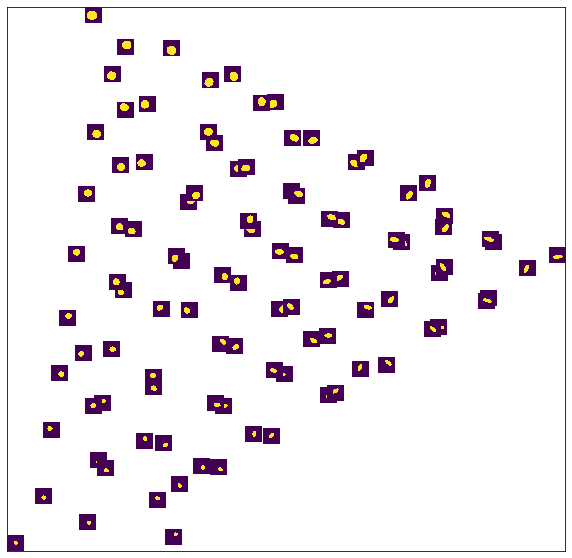

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
utils.plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax)


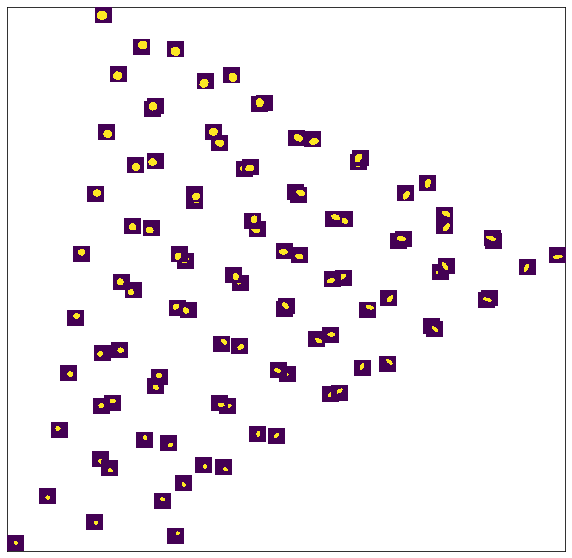

In [ ]:
i = 8
fig,ax = plt.subplots(figsize=(10,10))
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding2 = mds.fit_transform(LGW_per_ref[i])
utils.plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding2[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax)


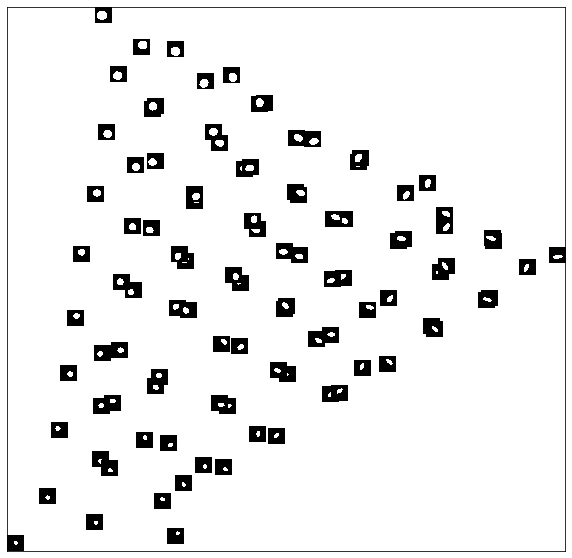

In [ ]:
i = 8
fig,ax = plt.subplots(figsize=(10,10))
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding2 = mds.fit_transform(LGW_per_ref[i])
plot_2d_shape_embedding(ells_flat.reshape(N,-1), embedding2[:, :2],
                              min_dist=1.0, figsize=(10,10), cutoff=0, save_path=None,font_size=15,axex=ax)


In [ ]:
print("        MRE       PCC      time in mins     no. of points")
for i in range(9):
    m_gw = np.ma.masked_equal(gw, 0.0, copy=False)
    m_lgw = np.ma.masked_equal(LGW_per_ref[i], 0.0, copy=False)
    print("Ref " + str(i+1) + ":  " 
          + str(np.round(np.mean(np.abs(m_gw - m_lgw)/m_gw),4)) 
          + "    " 
          + str(np.round(np.corrcoef(gw.flatten(),m_lgw.flatten())[1,0],4))
          + "    "
          + str(np.round((times_per_ref[i])/60,2))
          + "             "
          + str(np.sum(imgs[i] != 0)))

        MRE       PCC      time in mins     no. of points
Ref 1:  0.3357    0.8906    2.78             441
Ref 2:  0.3247    0.8756    15.92             676
Ref 3:  0.3178    0.8865    11.77             625
Ref 4:  0.1576    0.9863    0.13             52
Ref 5:  0.0376    0.9987    1.54             289
Ref 6:  0.03    0.9991    5.45             545
Ref 7:  0.0167    0.9993    7.68             882
Ref 8:  0.016    0.9993    8.28             882
Ref 9:  0.019    0.9993    2.06             317


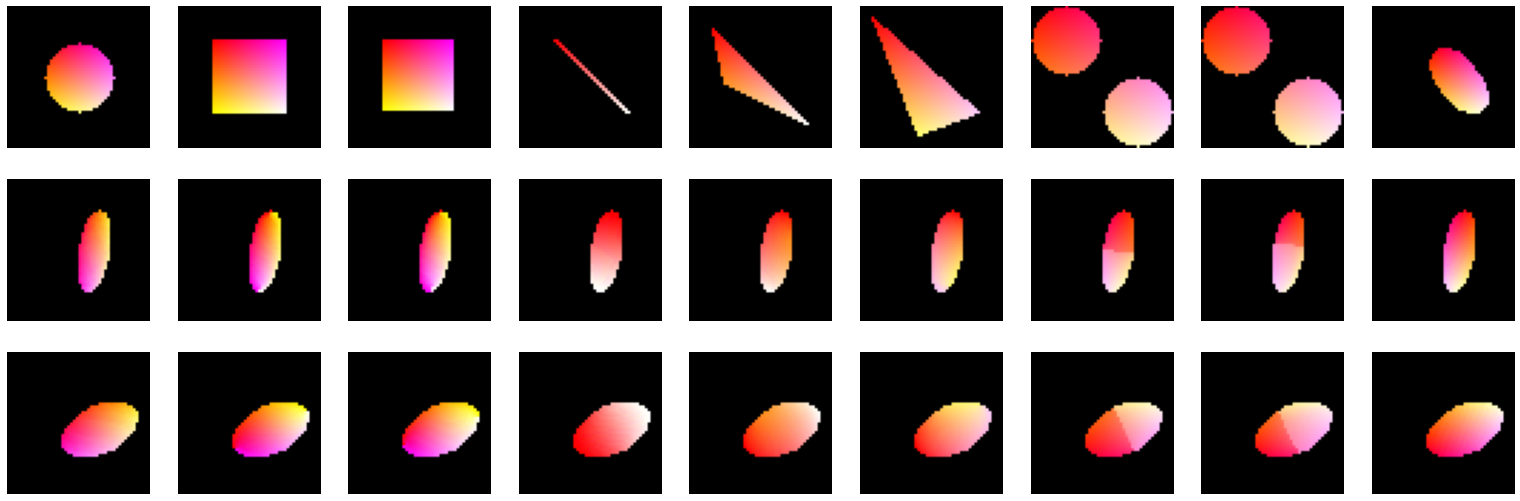

In [ ]:
fig, ax = plt.subplots(3,9,figsize=(27,9))
nos = [90,93]
for i in range(9):
    img1,img2 = vis_gw_plan(imgs[i],refs[i][0],posns[nos[0]],ot.unif(len(posns[nos[0]])),Ps_per_ref[i][nos[0]],return_img=True,plot_img=False,sub_box=True)   
    ax[0,i].imshow(img1)
    ax[0,i].axis("off")
    
    ax[1,i].imshow(img2)
    ax[1,i].axis("off")
    
    img3 = vis_gw_plan(imgs[i],refs[i][0],posns[nos[1]],ot.unif(len(posns[nos[1]])),Ps_per_ref[i][nos[1]],return_img=True,plot_img=False,sub_box=True)[1]   
    ax[2,i].imshow(img3)
    ax[2,i].axis("off")